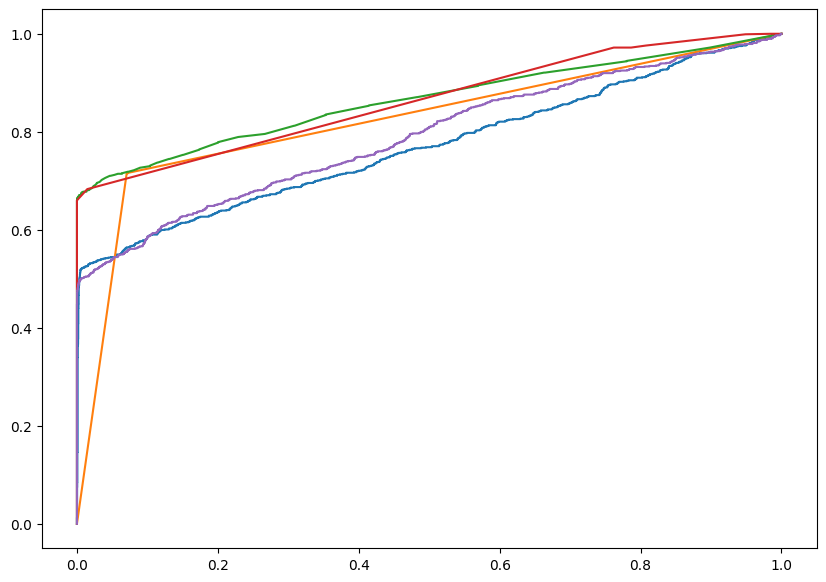

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
DataFrame = pd.read_csv(r"cbedatafinal2.csv")
DataFrame = DataFrame.dropna()
columns_to_drop_early = ["OPENING_DATE", "AccountNumber", "INACTIVE"]
DataFrame = DataFrame.drop(columns=columns_to_drop_early, errors='ignore')
y_raw = DataFrame['churn']
X_raw = DataFrame.drop(columns=['churn'])

categorical_features_for_X = [
    "type of account", "Mobile user", "has ATM CARD", "CURRENCY", "Job type", "GENDER"
]
x_encoded_features = pd.get_dummies(
    X_raw,
    columns=categorical_features_for_X,
    drop_first=True,
    dtype=int
)

label_encoder = LabelEncoder()
y_encoded_target = label_encoder.fit_transform(y_raw)
x = x_encoded_features
y = y_encoded_target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
models = [
    ('Logistic Regression', LogisticRegression(random_state=42, max_iter=1000)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('AdaBoost', AdaBoostClassifier(n_estimators=50, random_state=42)),
    ('SVM (RBF)', SVC(probability=True, random_state=42)),
]



results = []

plt.figure(figsize=(10, 7))
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        y_proba = model.decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min() + 1e-6)

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)

    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    results.append({
        'Model': name,
        'Accuracy': acc,
        'ROC AUC': roc_auc,
        'Confusion Matrix': cm
    })



/tmp/ipython-input-3034211758.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


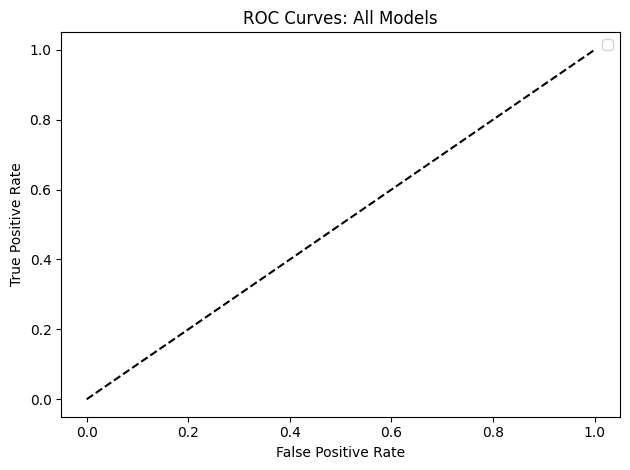

                 Model  Accuracy   ROC AUC
3             AdaBoost  0.945667  0.863188
2        Random Forest  0.944667  0.863592
1        Decision Tree  0.895167  0.822470
0  Logistic Regression  0.889167  0.770194
4            SVM (RBF)  0.882833  0.790151


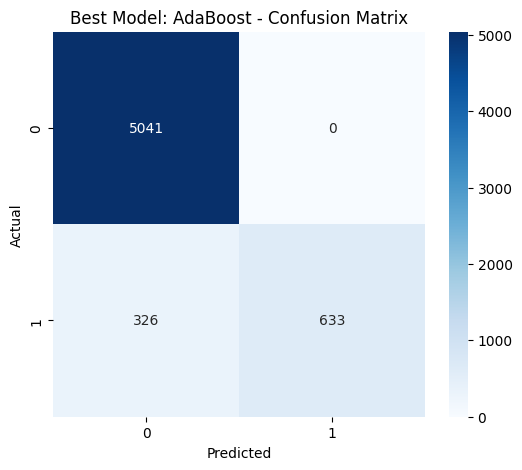


Best Model: AdaBoost with Accuracy: 0.9457 and ROC AUC: 0.8632


In [4]:

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: All Models')
plt.legend()
plt.tight_layout()
plt.show()
results_df = pd.DataFrame([{k: v for k, v in res.items() if k != 'Confusion Matrix'} for res in results])
print(results_df.sort_values('Accuracy', ascending=False))
best_idx = np.argmax(results_df['Accuracy'])
best_cm = results[best_idx]['Confusion Matrix']
plt.figure(figsize=(6,5))
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f"Best Model: {results[best_idx]['Model']} - Confusion Matrix")
plt.show()

print(f"\nBest Model: {results[best_idx]['Model']} with Accuracy: {results[best_idx]['Accuracy']:.4f} and ROC AUC: {results[best_idx]['ROC AUC']:.4f}")